In [1]:
!pip install torchinfo

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

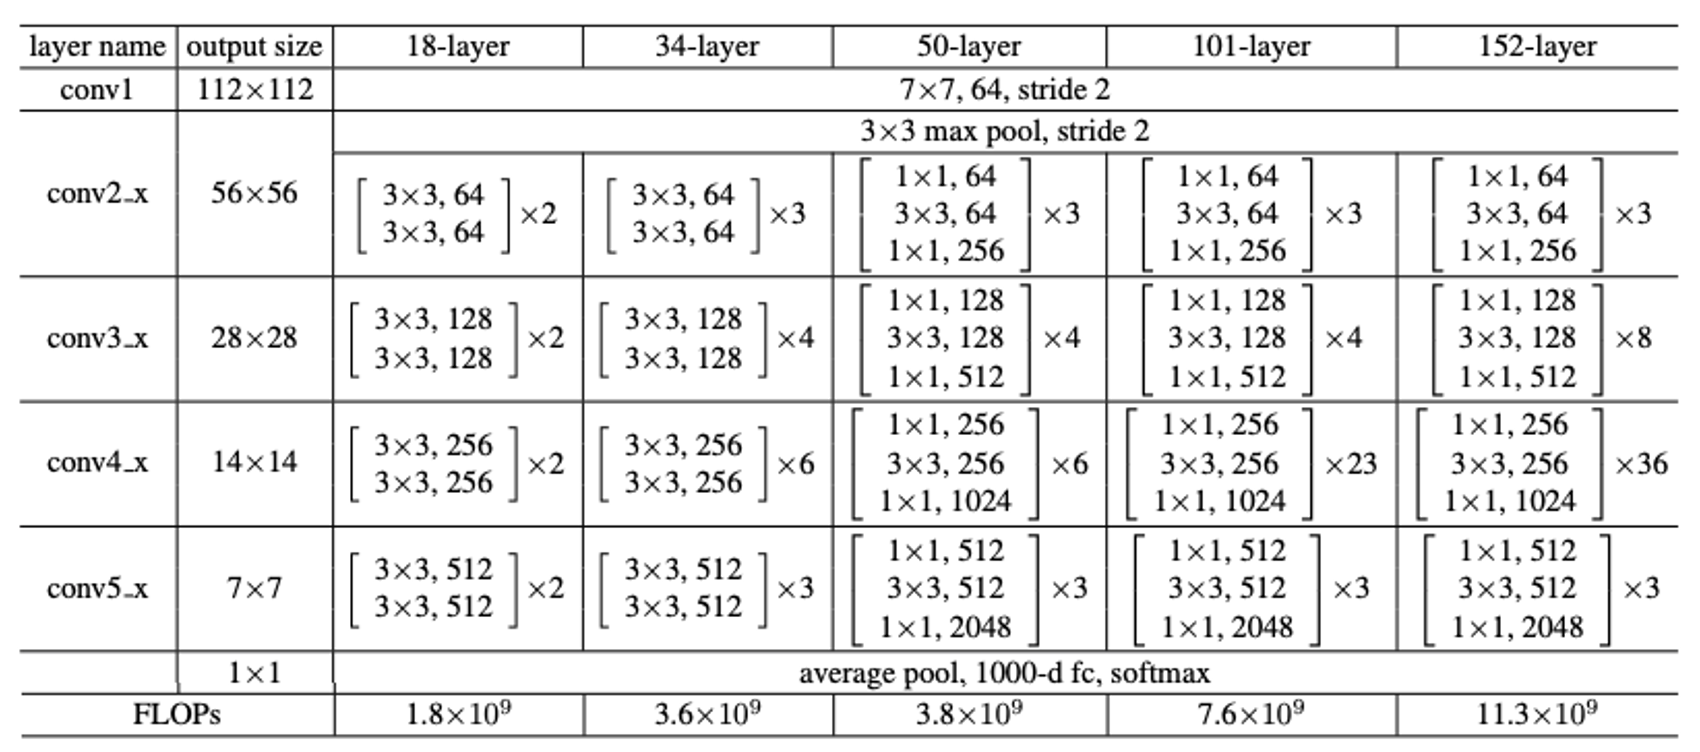

In [3]:
# BasicBlock: ResNet-18, ResNet-34에서 사용하는 기본 블록
class BasicBlock(nn.Module):
    expansion = 1  # 출력 채널 확장 비율

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

# Bottleneck: ResNet-50, ResNet-101, ResNet-152에서 사용하는 블록
class Bottleneck(nn.Module):
    expansion = 4  # Bottleneck 블록은 출력 채널이 4배

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

# ResNet 모델 클래스
class ResNet(nn.Module):
    # ResNet(BasicBlock, [2, 2, 2, 2], 1000)
    def __init__(self, block, layers, num_classes=1000):
        """
        Args:
            block: 사용할 블록 (BasicBlock 또는 Bottleneck)
            layers: 각 스테이지별 블록 개수 리스트 (예: [2, 2, 2, 2] for ResNet-18)
            num_classes: 분류할 클래스 수
        """
        super(ResNet, self).__init__()
        self.in_channels = 64
        # 초기 Convolution, BatchNorm, ReLU, MaxPool
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 각 스테이지별 Residual Layer 구성
        self.layer1 = self._make_layer(block, 64,  layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # 가중치 초기화
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        # stride가 1이 아니거나 입력/출력 채널 수가 다르면 다운샘플링 수행
        # 즉, Basic block 쓰는 18, 34-layer의 stage 1에서만 None, BottleNeck 쓰는 50, 101, 152-layer는 모든 stage에서 항상 여기로 들어옴

        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [4]:
from torchvision import models
from torchinfo import summary


resnet18 = ResNet(BasicBlock, [2, 2, 2, 2], 1000)
resnet34 = ResNet(BasicBlock, [3, 4, 6, 3], 1000)
resnet50 = ResNet(Bottleneck, [3, 4, 6, 3], 1000)
resnet101 = ResNet(Bottleneck, [3, 4, 23, 3], 1000)
resnet152 = ResNet(Bottleneck, [3, 8, 36, 3], 1000)
torch_model = models.resnet34(weights="ResNet34_Weights.IMAGENET1K_V1")

resnet34_info = summary(resnet34, (1, 3, 224, 224), verbose=0)
torch_model_info = summary(torch_model, (1, 3, 224, 224), verbose=0)

print(resnet34_info.total_params)
print(torch_model_info.total_params)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 162MB/s]


21797672
21797672


In [5]:
summary(resnet34, input_size=(2,3,224,224), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [2, 1000]                 --
├─Conv2d: 1-1                            [2, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [2, 64, 112, 112]         128
├─ReLU: 1-3                              [2, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [2, 64, 56, 56]           --
├─Sequential: 1-5                        [2, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [2, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [2, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [2, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [2, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [2, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [2, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [2, 64, 56, 56]           --
│

In [ ]:
from torchinfo import summary

summary(resnet152, input_size=(2,3,224,224), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [2, 1000]                 --
├─Conv2d: 1-1                            [2, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [2, 64, 112, 112]         128
├─ReLU: 1-3                              [2, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [2, 64, 56, 56]           --
├─Sequential: 1-5                        [2, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [2, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [2, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [2, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [2, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [2, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [2, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [2, 64, 56, 56]           --
│ 